<a id='sect0'></a>
## <font color='darkblue'>Preface</font>
From [**Issue4**](https://github.com/johnklee/ff_crawler/issues/4), we are going to work on the model to extract NER from article/post of Reddit based on inital labelled document [here](https://docs.google.com/document/d/1ACU5iDe6QkLZuMzyzaR0e_TUtw8Bht_IvQpO6_AZuCI/edit?usp=sharing&resourcekey=0-7WPgbTf3MfSIWZnIugZjxg):
* <font color='orange'>**Pixel phone model**</font>: T1
* <font color='green'>**Remote model**</font>: T2
* <font color='LightCoral'>**Symptom**</font>: T3
* <font color='Indigo'>**Recover way**</font>: T4
* <font color='LightSkyBlue'>**Build**</font>: T5
* <font color='Khaki'>**Reference phone**</font>: T6

In [1]:
import os
import json
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 1
TEST_SIZE = 0.2

# https://www.w3schools.com/colors/colors_names.asp
# https://gist.github.com/jonsuh/3c89c004888dfc7352be
class color:
   LIGHTCORAL='\033[38;2;240;128;128m'
   LIGHTSKYBLUE='\033[38;2;135;206;250m'
   KHAKI='\033[38;2;240;230;140m'
   INDIGO='\033[38;2;72;0;130m'
   ORANGE='\033[38;2;255;165;0m'
   LIGHTRED='\033[1;31m'
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'>[**Data Set**](#sect1)</font>
* <font size='3ptx'>[**Reddit APIs**](#sect2)</font>
  * [PRAW APIs to pull posts](#sect2_1)
* <font size='3ptx'>[**Word2vec Solution**](#sect3)</font>
* <font size='3ptx'>[**ML Models**](#sect4)</font>

## <font color='darkblue'>Data Set</font> ([back](#sect0))
We collect and label our data from dumped data [here](https://drive.google.com/file/d/1LTyPKtafRQnQp-DslpjBM5QUWoxAtSTY/view?usp=sharing). Let's load labelling data back for future process:

In [2]:
df = pd.read_csv("issue4_data.csv")
df.head()

,source,sentence
0,https://www.reddit.com/r/GooglePixel/comments/kspwba/bluetooth_is_terrible/,My P4a5g\_T1 keeps having bluetooth problems .
1,https://www.reddit.com/r/GooglePixel/comments/kspwba/bluetooth_is_terrible/,I have the sony\_T2 wh-1000mx4\_T2 and they just keep\_T3 disconnecting\_T3 .
2,https://www.reddit.com/r/GooglePixel/comments/kspwba/bluetooth_is_terrible/,But once I pause\_T3 the\_T3 media\_T3 it\_T3 disconnects\_T3 and I have to restart\_T4 the\_T4 bluetooth\_T4 on\_T4 my\_T4 phone\_T4 to\_T4 get\_T4 it\_T4 to\_T4 reconnect\_T4 .
3,https://www.reddit.com/r/GooglePixel/comments/kspwba/bluetooth_is_terrible/,Does anyone else having this problem or are my settings wrong somewhere .
4,https://www.reddit.com/r/GooglePixel/comments/lgofla/pixel_4a_5g_bluetooth_issues/,Pixel\_T1 4a\_T1 5g\_T1 Bluetooth issues


In [3]:
word_set = set()
label_t1 = label_t2 = label_t3 = label_t4 = label_t5 = label_t6 = label_o = 0
for ri, r in df.iterrows():
    words = r.sentence.split()
    for i in range(len(words)):                
        # if words[i][-1] in ",.!?":
        #    words[i] = words[i][:-1]
        #elif words[i][-2:] == "'s":
        #    words[i] = words[i][:-2]
            
        if words[i].startswith('('):
            words[i] = words[i][1:]
            
        if words[i].endswith(')'):
            words[i] = words[i][:-1]
            
    new_words = []
    for w in words:
        if w.endswith('\_T1'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.ORANGE}{w}{color.END}"
            label_t1 += 1
            
        elif w.endswith('\_T2'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.GREEN}{w}{color.END}"
            label_t2 += 1
            
        elif w.endswith('\_T3'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.LIGHTCORAL}{w}{color.END}"
            label_t3 += 1
            
        elif w.endswith('\_T4'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.INDIGO}{w}{color.END}"
            label_t4 += 1
            
        elif w.endswith('\_T5'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.LIGHTSKYBLUE}{w}{color.END}"
            label_t5 += 1
            
        elif w.endswith('\_T6'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.KHAKI}{w}{color.END}"
            label_t6 += 1
            
        else:
            label_o += 1
            
        new_words.append(w)
        
    print(" ".join(new_words))

My P4a5g keeps having bluetooth problems .
I have the sony wh-1000mx4 and they just keep disconnecting .
But once I pause the media it disconnects and I have to restart the bluetooth on my phone to get it to reconnect .
Does anyone else having this problem or are my settings wrong somewhere .
Pixel 4a 5g Bluetooth issues
I have been having issues with Bluetooth connectivity with the new pixel 4a 5g .
1st it started with my Fitbit where the app would occasionally not find the device and I would need to forget and add the Fitbit again .
More recently it has issues where the Bluetooth connection to car audio or wireless earphones keeps dropping whenever I switch between apps like spotify and Google maps or podcasts and Strava .
Pixel 4a 5g constantly dropping bluetooth
Both my Bose QC 35 headphones and a bluetooth speaker disconnect and reconnect when no audio is playing .
This did not happen on my Pixel 3a , Nexus 6P or Galaxy S7 .
Song information over Bluetooth with Pixel 5 ?
Has anyon

In [4]:
for n, v in sorted(
        [(n, v) for n, v in globals().items() if n.startswith('label_t') or n.startswith('label_o')],
        key=lambda t: t[0]):
    print(f"{n}: {v}")

label_o: 280
label_t1: 24
label_t2: 19
label_t3: 164
label_t4: 17
label_t5: 6
label_t6: 9


We store a list of car brands for future reference and process in file `car_brand_list.txt`.

In [5]:
phone_brand_set = set()
with open('phone_brands.txt', 'r') as fo:
    for line in fo:
        line = line.lower()
        phone_brand_set.add(tuple(list(map(lambda w: w.lower(), line.split()))))
    
list(phone_brand_set)[:10]

[('pixel',), ('nexus',), ('apple',), ('galaxy',)]

In [6]:
device_brand_set = set()
with open('remote_device_brands.txt', 'r') as fo:
    for line in fo:
        line = line.lower()
        device_brand_set.add(tuple(list(map(lambda w: w.lower(), line.split()))))
    
list(device_brand_set)[:10]

[('fitbit',)]

We also keep many post to hold content without desired entity which can be used for training in directory `negative_posts`:

In [7]:
NEGATIVE_DIR_PATH = 'negative_posts'

## <font color='darkblue'>Reddit APIs</font>
Here we are going to pull posts/articles from [**Reddits**](https://www.reddit.com/) by APIs of [**PRAW**](https://praw.readthedocs.io/en/latest/) to help us collect more posts/articles for labelling process:
1. Pull posts from Reddit by open API
2. Train a classifier to select the post we are interested (contains the labels we want)

In [12]:
#!pip install praw

<a id='sect2_1'></a>
### <font color='darkgreen'>PRAW APIs to pull posts</font>
First step, we are going to pull posts from Reddit and then do manual labelling to separate the wanted posts and others:
* Follow [this post](https://www.jcchouinard.com/get-reddit-api-credentials-with-praw/) to retrieve the client id, secret which will be provided into API later. (We store the credentials in `client_secrets.json` here. If this is your first time to use this script, try to create a reddit app [here](https://www.reddit.com/prefs/apps/))

In [19]:
import logging
import praw
import json

with open('client_secrets.json', 'r') as fo:
    reddit_credentials = json.load(fo)
    rdt_agent = praw.Reddit(**reddit_credentials)


# Make sure you can see your name to indicate that you are ready to use APIs
rdt_agent.user.me()

Redditor(name='johnkclee')

* Now our PRAW APIs are ready to use. Let's pull a few post for our reference as prior run:
  * [**Reddit** (rdt_agent)](https://praw.readthedocs.io/en/latest/code_overview/reddit_instance.html?highlight=Reddit#the-reddit-instance): The Reddit class provides convenient access to Reddit’s API.
  * [**Subreddit** (st_googlepixel)](https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html?highlight=Subreddit#subreddit): A class for Subreddits.
  * [**Submission** (submission)](https://praw.readthedocs.io/en/latest/code_overview/models/submission.html#praw.models.Submission): A class for submissions to reddit.

In [22]:
# Create a sub-reddit object for topic we are interested in (r/GooglePixel)
st_googlepixel = rdt_agent.subreddit("GooglePixel")

print(st_googlepixel.display_name)
# Output: redditdev
#print(st_googlepixel.title)
# Output: reddit development
#print(st_googlepixel.description)
# Output: a subreddit for discussion of ...

GooglePixel


In [31]:
# Obtain Submission Instances from a sub-reddit
for submission in st_googlepixel.new(limit=5):
    print(color.BOLD + submission.title + color.END)
    # Output: the submission's title
    print(submission.score)
    # Output: the submission's score
    print(submission.id)
    # Output: the submission's ID
    print(submission.url)
    # Output: the URL the submission points to or the submission's URL if it's a self post
    print("\n" + submission.selftext + "\n\n")
    # Output: The body of submission

Shafted by garbage Verizon policies, looking for a way out
0
n6okhc
https://www.reddit.com/r/GooglePixel/comments/n6okhc/shafted_by_garbage_verizon_policies_looking_for_a/

Hi everyone, you'll have to pardon my ignorance with all of this security stuff. I was into doing hacky stuff to my phone as a kid, but became a good complacent little sheep in college, and am just now starting to take the cybersecurity plunge.

I've recently, but not recently enough (November 2020 ish so I'm outside of the warranty window) upgraded with Verizon's edge plan to a Pixel 5. I've been loyal to Pixel ever since the first one, and I've always gone with them because I've always tried to be at least a little privacy conscious, for a normie, and I only use my phone as a bootloader for Reddit and a web browser anyway so I didn't want any Samsung or Apple crapware on there.

So when, as usual, I broke my phone beyond usability, I decided to upgrade to the Pixel 5 with the intention of putting GrapheneOS on the

* If you can see pulled posts from above code snippet, then it is ready to pull volume of posts now:

In [48]:
import pickle
import os
import time
from logb import get_logger
from datetime import datetime
from typing import Dict
from tqdm import tqdm

ROOT_PATH = os.getcwd()
CACHE_PKL_NAME = os.path.join(ROOT_PATH, 'reddit_pulled_post_cache.pkl')
DUMP_DIR_PATH = os.path.join(ROOT_PATH, "reddit_post_dumps")
PULL_SIZE_LIMIT = 1000
logger = get_logger("issue4")

def get_ts() -> int:
    return int(datetime.now().timestamp())

def get_datestr() -> str:
    return datetime.now().strftime("%Y%m%d%H%M%S")

def dump_reddit_post(datestr, submission):
    url = submission.url.split('?')[0]
    if url.endswith('/'):
        url = url[:-1]
        
    def _save(fn):
        with open(os.path.join(DUMP_DIR_PATH, fn), 'w', encoding='utf-8') as fw:
            fw.write(submission.url + "\n\n")
            fw.write(submission.title + "\n\n")
            fw.write(submission.selftext)
            
    try:
        id_with_title = '_'.join(url.split('/')[-2:])
        fn = f"{datestr}_{id_with_title}.txt"
        _save(fn)
    except Exception:
        logger.warning(f"Fail to use fn={fn} with URL={url}")
        fn = f"{datestr}_{submission.id}.txt"
        logger.warning(f"Using fn={fn} instead...")
        _save(fn)

def load_rpp_cache() -> Dict[str, float]:
    """ Load Reddit pulled post cache"""
    cache_dict = {} # Key as URL, value as pulling stamp    
    if os.path.isfile(CACHE_PKL_NAME):
        try:
            with open(CACHE_PKL_NAME, 'rb') as fo:
                cache_dict = pickle.load(fo)
        except:
            logger.warning(f"Fail to load back {CACHE_PKL_NAME}!")            
            os.remove(CACHE_PKL_NAME)
            return {}
    
    return cache_dict
        
def save_rpp_cache(cache_dict:Dict[str,float]):
    """ Save Reddit pulled post cache"""
    with open(CACHE_PKL_NAME, 'wb') as fw:
        pickle.dump(cache_dict, fw)
        
### Start the Reddit dump process
rppc_cache = load_rpp_cache()

if not os.path.isdir(DUMP_DIR_PATH):
    os.makedirs(DUMP_DIR_PATH)
    
st = datetime.now()
datestr = get_datestr()
print(f"Start Reddit dumping at {datestr}...")
time.sleep(1)
# Obtain Submission Instances from a sub-reddit
new_post_count = 0
with tqdm(total=PULL_SIZE_LIMIT) as pbar:
    pc = 0
    for submission in st_googlepixel.new(limit=PULL_SIZE_LIMIT):
        if submission.url not in rppc_cache:
            rppc_cache[submission.url] = get_ts()
            dump_reddit_post(datestr, submission)
            new_post_count += 1
            
        pbar.update(1)
        pc += 1
        
    pbar.update(PULL_SIZE_LIMIT - pc)
    
logger.info(f"Total {new_post_count:,d} new post collected! ({datetime.now() - st})")
save_rpp_cache(rppc_cache)

Start Reddit dumping at 20210507142255...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.11it/s]
MainThread/INFO: <<ipython-input-48-e68b0d38a75b>#86> Total 0 new post collected! (0:00:14.319820)


Above code has been refactored and we will use script `reddit_dumper.py` to dump posts of Reddit instead in server.

<a id='sect2'></a>
## <font color='darkblue'>Word2vec Solution</font> ([back](#sect0))
* [**Fasttext**](#sect2_1)
* [**Gensim**](#sect2_2)

[**Word2vec**](https://en.wikipedia.org/wiki/Word2vec) is a technique for [natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing). The word2vec algorithm uses a neural network model to learn word associations from a large [corpus of text](https://en.wikipedia.org/wiki/Corpus_of_text). Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence.
![1.png](images/1.png)
<br/>

<a id='sect2_1'></a>
### <font color='darkgreen'>Fasttext - Word to vector</font>
Here we will leverage [**Fasttext**](https://github.com/facebookresearch/fastText) package to help us to translate word into vector for later ML training. Instead of re-training a new Fasttext model, we will use exist trained model [here](https://fasttext.cc/docs/en/crawl-vectors.html) [cc.en.300.bin.gz](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz). Please click the link and download it:

In [7]:
#!pip install fasttext

In [8]:
#import fasttext.util

#fasttext.util.download_model('en', if_exists='ignore')  # English
#ft = fasttext.load_model('cc.en.300.bin')

After that, below code will load the downloaded model:

In [9]:
#import fasttext
#import fasttext.util

<a id='sect2_2'></a>
### <font color='darkgreen'>Gensim - Word to vector</font>
Here we will leverage [**Gensim**](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) to help us to translate word into vector for later ML training.

In [8]:
# Load in word vector translator
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
unknown_word_set = set()
for w in word_set:
    try:
        wv[w]
    except:
        unknown_word_set.add(w)
        
print(f"Total {len(unknown_word_set)} unknown word(s) found!")
print(unknown_word_set)

Total 12 unknown word(s) found!
{'6-digit', 'and', 'spotify', 'a', 'smartwatch', 'to', '10', 'wh-1000mx4', 'W10', 'P4a5g', '11', '35'}


<a id='sect3'></a>
## <font color='darkblue'>ML Models</font>
Here we are going to explore some ML solutions to deal with NER problem.

### <font color='darkgreen'>CRF </font>
Pleae refer to this [notebook](https://nbviewer.jupyter.org/github/johnklee/ml_articles/blob/master/medium/NLP_Guide_Identifying_Part_of_Speech_Tags_using_Conditional_Random_Fields/notebook.ipynb) for more details.

In [12]:
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold,StratifiedKFold
from collections import Counter
import nltk
#nltk.download("punkt")

In [13]:
def is_car_brand(sentence, index):
    for car_brand in car_brand_set:
        if ' '.join(car_brand) == ' '.join(list(map(lambda w: w.lower(), sentence[index:index+len(car_brand)]))):
            return 1
        
    return 0

def crf_features(sentence, index):
    ### sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    return {
        'is_car_brand': is_car_brand(sentence, index),
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'prev_2word':'' if index<=1 else ''.join(sentence[index-2:index]),
        'prev_3word':'' if index<=2 else ''.join(sentence[index-3:index]),
        'next_word':'' if index<=len(sentence)-1 else sentence[index+1],
        'next_2word':'' if index<=len(sentence)-2 else sentence[index+1:index+2],
        'next_3word':'' if index<=len(sentence)-3 else sentence[index+1:index+3],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index])))),
        'prefix_1':sentence[index][0],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0  
    }

In [14]:
# See if a word combination is treated a car brand or not
is_car_brand(['bmw'], 0)

1

In [15]:
# See how a sentence is translated into CRF feature vector
for ri, r in df.iterrows():
    if '\_a' in r.sentence and '\_h' in r.sentence:
        print(r.sentence)
        words_with_label = nltk.tokenize.word_tokenize(r.sentence)
        words, tags = [], []
        for w in words_with_label:
            if w.endswith('\_h'):
                tags.append('c')
                w = w [:-3]
            elif w.endswith('\_a'):
                tags.append('a')
                w = w [:-3]
            else:
                tags.append('o')
            words.append(w)
          
        print(f"words: {words}\nlabels: {tags}\n")
        feat_4word = [crf_features(words, i) for i in range(len(words))][3]        
        print(json.dumps(feat_4word, sort_keys=True, indent=4))
        # y.append(tags)
        break

Mine is a Nissan\_h Frontier\_h with an aftermarket Kenwood\_a touchscreen\_a radio\_a by the way.
words: ['Mine', 'is', 'a', 'Nissan', 'Frontier', 'with', 'an', 'aftermarket', 'Kenwood', 'touchscreen', 'radio', 'by', 'the', 'way', '.']
labels: ['o', 'o', 'o', 'c', 'c', 'o', 'o', 'o', 'a', 'a', 'a', 'o', 'o', 'o', 'o']

{
    "is_alphanumeric": 0,
    "is_car_brand": 1,
    "is_complete_capital": 0,
    "is_first_capital": 1,
    "is_first_word": 0,
    "is_last_word": 0,
    "is_numeric": 0,
    "next_2word": "",
    "next_3word": "",
    "next_word": "",
    "prefix_1": "N",
    "prefix_2": "Ni",
    "prefix_3": "Nis",
    "prefix_4": "Niss",
    "prev_2word": "isa",
    "prev_3word": "Mineisa",
    "prev_word": "a",
    "suffix_1": "n",
    "suffix_2": "an",
    "suffix_3": "san",
    "suffix_4": "ssan",
    "word_has_hyphen": 0
}


In [50]:
class_names = ['o', 'c', 'a']

def get_crf_data():    
    X, y = [], []
    for ri, r in df.iterrows():
        words_with_label = nltk.tokenize.word_tokenize(r.sentence)
        words, tags = [], []
        for w in words_with_label:
            if w.endswith('\_h'):
                tags.append('c')
                w = w [:-3]
            elif w.endswith('\_a'):
                tags.append('a')
                w = w [:-3]
            else:
                tags.append('o')
            words.append(w)
            
        X.append([crf_features(words, i) for i in range(len(words))])
        y.append(tags)
        
    for f in os.listdir(NEGATIVE_DIR_PATH):
        fp = os.path.join(NEGATIVE_DIR_PATH, f)
        with open(fp, 'r', encoding='utf8') as fo:
            for i in range(4):
                fo.readline()  # Skip URL and title
                
            post_content = fo.read()
            sentences = list(filter(lambda s: s, map(lambda s: s.strip(), nltk.sent_tokenize(post_content))))
            for sent in sentences:
                tokens = nltk.tokenize.word_tokenize(sent)
                X.append([crf_features(tokens, i) for i in range(len(tokens))])
                y.append(['o'] * len(tokens))
                    
    return X, y

In [17]:
# https://ithelp.ithome.com.tw/articles/10222958
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(12,6))  #調整圖的大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, 
        X, 
        y, 
        cv=cv, 
        n_jobs=n_jobs, 
        train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [51]:
X, y = get_crf_data()
print(f"We total have {len(X):,d} records for training!")

We total have 880 records for training!


In [33]:
def crf_train_test_split(X, y, test_size, random_state=RANDOM_STATE):
    X_train, X_test, y_train, y_test = [], [], [], []
    yi_has_ca_label = []
    yi_only_o_label = []
    for yi in range(len(y)):
        y_labels = y[yi]
        if all(list(map(lambda t: t=='0', y_labels))):
            yi_only_o_label.append(yi)
        else:
            yi_has_ca_label.append(yi)
            
    random.seed(random_state)
    for yi_group in [yi_has_ca_label, yi_only_o_label]:
        for i in yi_group:
            if random.random() > test_size:
                X_train.append(X[i])
                y_train.append(y[i])
            else:
                X_test.append(X[i])
                y_test.append(y[i])
                
    return X_train, X_test, y_train, y_test

In [67]:
X_train, X_test, y_train, y_test = crf_train_test_split(X, y, 0.2)

In [68]:
%%time
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

Wall time: 1.14 s


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.01, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [69]:
y_pred=crf.predict(X_test)
print("F1 score on Test Data ")
print(f"{metrics.flat_f1_score(y_test, y_pred,average='weighted', labels=crf.classes_):.05f}")

### Look at class wise score
print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf.classes_, digits=3
))

F1 score on Test Data 
0.99192
              precision    recall  f1-score   support

           o      0.993     1.000     0.997      4247
           c      0.966     0.667     0.789        42
           a      0.889     0.348     0.500        23

    accuracy                          0.993      4312
   macro avg      0.949     0.671     0.762      4312
weighted avg      0.993     0.993     0.992      4312



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

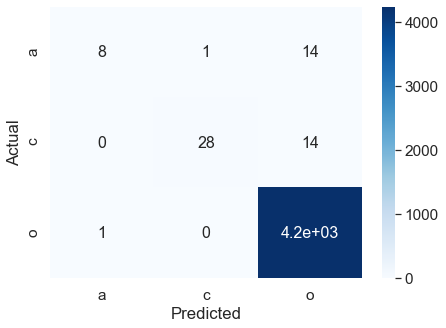

In [71]:
y_test_1d, y_pred_1d = [], []
for yorig, ynew in [(y_test, y_test_1d), (y_pred, y_pred_1d)]:
    for tags in yorig:
        for t in tags:
            ynew.append(t)
            
data = confusion_matrix(y_test_1d, y_pred_1d)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_1d), index = np.unique(y_test_1d))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [41]:
print("Number of Transition Features ")
len(crf.transition_features_)

Number of Transition Features 


9

In [22]:
Counter(crf.transition_features_).most_common(20)

[(('a', 'a'), 2.994266),
 (('o', 'o'), 2.181655),
 (('c', 'c'), 2.179429),
 (('c', 'o'), -1.554949),
 (('a', 'c'), -1.674058),
 (('o', 'a'), -1.720597),
 (('a', 'o'), -1.819191),
 (('o', 'c'), -1.832376),
 (('c', 'a'), -1.986582)]

In [23]:
print("Number of State Features ",len(crf.state_features_))

Number of State Features  4530


In [24]:
Counter(crf.state_features_).most_common(20)

[(('is_car_brand', 'c'), 2.785768),
 (('prev_word:The', 'a'), 1.465566),
 (('prefix_2:VW', 'c'), 1.423241),
 (('prev_word:,', 'o'), 1.367695),
 (('prev_3word:asdoesthe', 'o'), 1.360093),
 (('is_numeric', 'c'), 1.337133),
 (('prefix_3:Mer', 'c'), 1.334688),
 (('prefix_4:Merc', 'c'), 1.334688),
 (('is_last_word', 'o'), 1.316394),
 (('prev_2word:doesthe', 'o'), 1.28171),
 (("suffix_2:'s", 'c'), 1.181516),
 (('prefix_1:a', 'o'), 1.165886),
 (('is_first_capital', 'c'), 1.165151),
 (('prev_word:my', 'c'), 1.107591),
 (('prefix_2:Me', 'c'), 1.074723),
 (('prev_2word:A4(', 'c'), 1.0541),
 (('prev_3word:AudiA4(', 'c'), 1.0541),
 (('suffix_3:rus', 'c'), 1.050561),
 (('suffix_4:arus', 'c'), 1.050561),
 (('prev_2word:listedby', 'c'), 1.050463)]

Next, let's check how model improve along with the increase of training data size:

Wall time: 22.2 s


<module 'matplotlib.pyplot' from 'c:\\users\\john\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

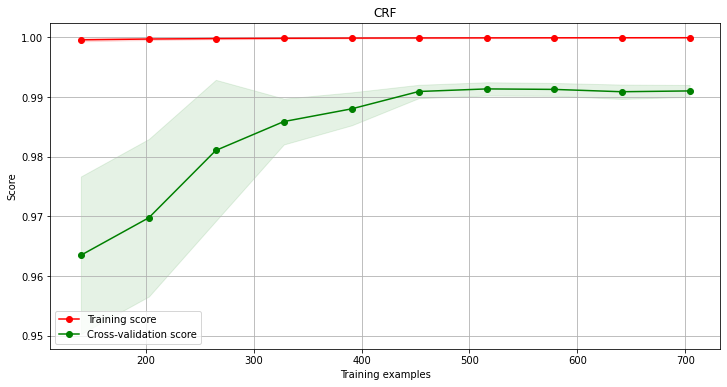

In [25]:
%%time
cv = KFold(
    n_splits=5,
    random_state=RANDOM_STATE, 
    shuffle=True
)

estimator = crf

plot_learning_curve(
    estimator, "CRF",
    X, 
    y, 
    cv=cv, 
    train_sizes=np.linspace(0.2, 1.0, 10)
)

#### Evaluation of model manually
Let's feed in our own sentence(s) and check how model perform in real world:

In [26]:
def sent2crf_feature(sent):
    words = list(nltk.tokenize.word_tokenize(sent))
    sent_crf_feat = [crf_features(words, i) for i in range(len(words))]
    return words, [sent_crf_feat]


def predict(sent):
    words, crf_feats = sent2crf_feature(sent)
    tags = crf.predict(crf_feats)[0]
    print(f"words={words}\ntags={tags}\n")
    colorful_words = []
    for w, t in zip(words, tags):
        if t == 'c':
            w = f"{color.BOLD}{color.BLUE}{w}{color.END}"
        elif t == 'a':
            w = f"{color.BOLD}{color.RED}{w}{color.END}"        
            
        colorful_words.append(w)
    
    print(" ".join(colorful_words))
    

In [27]:
my_sent="My car MAZDA MX-5 RF has bluetooth pairing issue."
predict(my_sent)

words=['My', 'car', 'MAZDA', 'MX-5', 'RF', 'has', 'bluetooth', 'pairing', 'issue', '.']
tags=['o', 'o', 'c', 'c', 'c', 'o', 'o', 'o', 'o', 'o']

My car MAZDA MX-5 RF has bluetooth pairing issue .


In [28]:
my_sent="Though my 2015 Subaru connected just fine even w/o needing that step."
predict(my_sent)

words=['Though', 'my', '2015', 'Subaru', 'connected', 'just', 'fine', 'even', 'w/o', 'needing', 'that', 'step', '.']
tags=['o', 'o', 'c', 'c', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']

Though my 2015 Subaru connected just fine even w/o needing that step .


In [29]:
my_sent="I’ve had exactly the same results with a ‘20 Chevy. "
predict(my_sent)

words=['I', '’', 've', 'had', 'exactly', 'the', 'same', 'results', 'with', 'a', '‘', '20', 'Chevy', '.']
tags=['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'c', 'c', 'o']

I ’ ve had exactly the same results with a ‘ 20 Chevy .


## <font color='darkblue'>Supplement</font>
* [All Car Brands](https://www.carlogos.org/car-brands/)
* [FAQ - How to handle unknown word in Gensim?](https://stackoverflow.com/questions/54709178/how-to-handle-words-that-are-not-in-word2vecs-vocab-optimally)
* [FAQ - How to use PRAW to read the newest post from a subreddit and display the body?](https://www.reddit.com/r/learnpython/comments/90asqi/how_to_use_praw_to_read_the_newest_post_from_a/)